Graph Convolutional Networks populates same weight for every neighbor. But this may not be necessarily true. Some nodes are more important than others! 

Graph Attention Networks offer a solution to this problem. To consider the importance of each neighbor, an attention mechanism assigns a weighting factor to every connection.

In [1]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [9]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")

data = dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {dataset[0].has_isolated_nodes()}')

Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


Let’s plot the number of connections of each node with degree:

<BarContainer object of 32 artists>

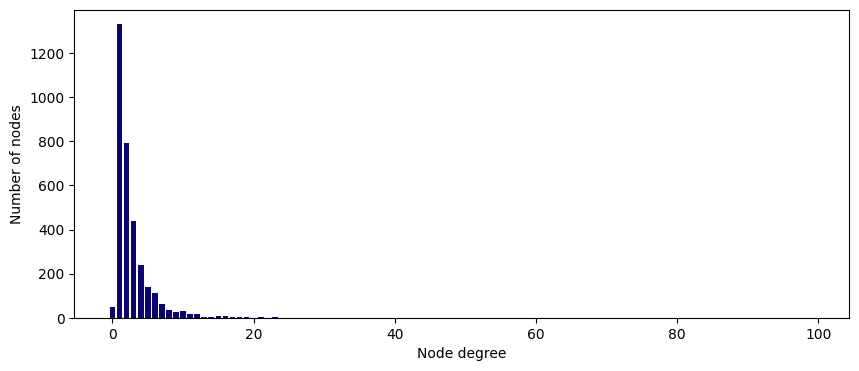

In [12]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [13]:
print('Max Node Degree: ', max(numbers, key=numbers.get), ', No. of edges: ', numbers[max(numbers, key=numbers.get)])
print('Min Node Degree: ', min(numbers, key=numbers.get), ', No. of edges: ', numbers[min(numbers, key=numbers.get)])

Max Node Degree:  1.0 , No. of edges:  1331
Min Node Degree:  22.0 , No. of edges:  1


In [15]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [16]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'GCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.802 | Train Acc:  16.67% | Val Loss: 1.78 | Val Acc: 17.80%
Epoch  10 | Train Loss: 0.436 | Train Acc:  95.83% | Val Loss: 1.23 | Val Acc: 57.60%
Epoch  20 | Train Loss: 0.149 | Train Acc:  97.50% | Val Loss: 1.26 | Val Acc: 60.00%
Epoch  30 | Train Loss: 0.088 | Train Acc:  97.50% | Val Loss: 1.42 | Val Acc: 57.60%
Epoch  40 | Train Loss: 0.067 | Train Acc:  98.33% | Val Loss: 1.46 | Val Acc: 60.60%
Epoch  50 | Train Loss: 0.042 | Train Acc: 100.00% | Val Loss: 1.45 | Val Acc: 58.80%
Epoch  60 | Train Loss: 0.044 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 57.60%
Epoch  70 | Train Loss: 0.043 | Train Acc: 100.00% | Val Loss: 1.48 | Val Acc: 57.40%
Epoch  80 | Train Loss: 0.035 | Train Acc:  99.17% | Val Loss: 1.55 | Val Acc: 60.00%
Epoch  90 | Train Loss: 0.029 | Train Acc: 100.00% | Val Loss: 1.52 | Val Acc: 60.00%
Epoch 100 | Train Loss: 0.048 | Train Acc:  98.33% | Val Loss: 1.49 | Val Acc: 6